## LOADING DATA


In [22]:
!pip install torchmetrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Datasets/bh2y_final/CVAE_example.py /content
!cp /content/drive/MyDrive/Datasets/bh2y_final/CVAE_func.py /content
!cp /content/drive/MyDrive/Datasets/bh2y_final/config_model.yaml /content

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Datasets/bh2y_final')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Datasets/bh2y_final')

## Environment & settings


In the Python script CVAE_func , along with functions for CVAE, i have added loss function addition capability so that there can be an efficient way to tune the hyperparameters. There are multiple ways we can do hyperparameter tuning,


1.   Manual Estimation using analysing plotted samples
2.   Grid Search
3.   Bayesian Optimization

In this Notebook , i will be exploring Manual Estimation , so as to get an idea of how CVAE works and changes in Loss function Hyperparameters can affect the model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics import MeanSquaredError

import torch.utils.data as data_utils


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yaml

#Module with all related CVAE functions: train, test, etc.
import CVAE_func as CVAE_fn

# Module with CVAE antares architecture
import CVAE_example as CVAE

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
# device = torch.device("mps")
device = torch.device("cuda" if cuda else "cpu")

def f_y_0(x0, x1):
    return np.sin(5 * x0 + 3 * x1)


def f_y_1(x0, x1):
    return np.cos(4 * x0 + 8 * x1)

functions = [f_y_0, f_y_1]

## 1. Prepare Dataset
### 1.1. Load Dataset


In [ ]:
data_root = './data_1/'  #edit it for you own path to datasets
filename = "_dataset"

filename_dataset = f'{data_root}train{filename}.pt'
filename_validation_dataset = f'{data_root}validation{filename}.pt'

dataset = CVAE_fn.SignalDataset(torch.load(filename_dataset))
dataset_validation = CVAE_fn.SignalDataset(torch.load(filename_validation_dataset))

print(f"Train dataset is loaded successfully and has length: {len(dataset)}")
print(f"Validation dataset is loaded successfully and has length: {len(dataset_validation)}")

# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = 100, shuffle=True)

# create a PyTorch DataLoader from the dataset_test
validation_loader = DataLoader(dataset_validation, batch_size=100, shuffle=True)

Train dataset is loaded successfully and has length: 100000
Validation dataset is loaded successfully and has length: 3000


### 1.2. Plot Random Samples

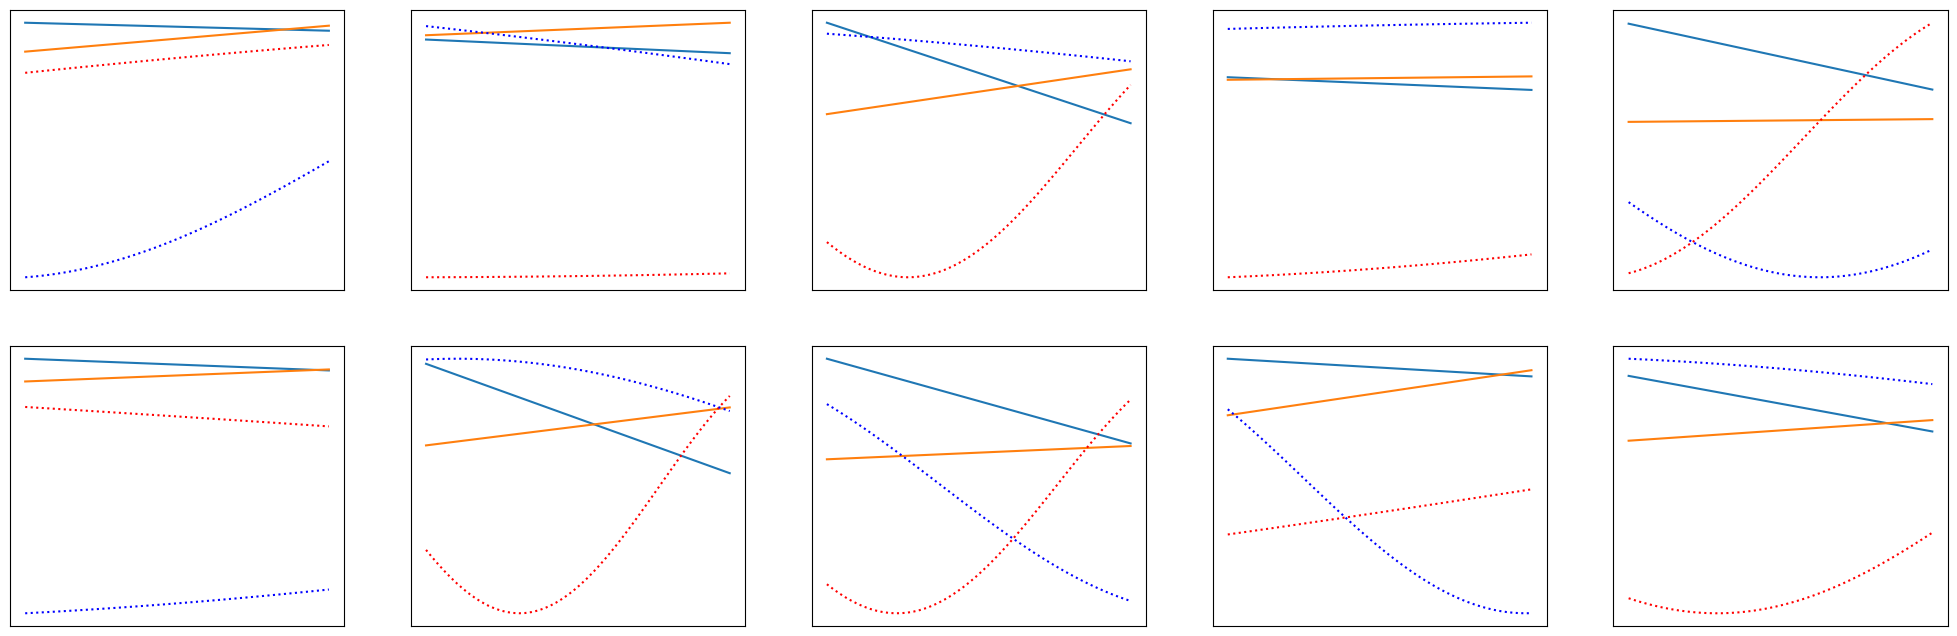

In [ ]:
x,y = next(iter(dataloader))
num_samples = 10

CVAE_fn.plot_samples(x, y, num_samples = num_samples,n_cols=5,fig_size=4)

## 2. Model setup and train
### 2.1. Define the model and optimizer



The Algorithm:

Loss function is the utmost important , the following is the loss function and the architecture:
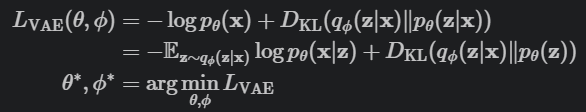

The above loss function is for the Variational Autoencoders, while conditional VAE has similar approach , except putting labels / conditions , i.e x chnges to x/c , x/z changes to x/z,c and z/x changes to z/x,c

The following is the architecture:

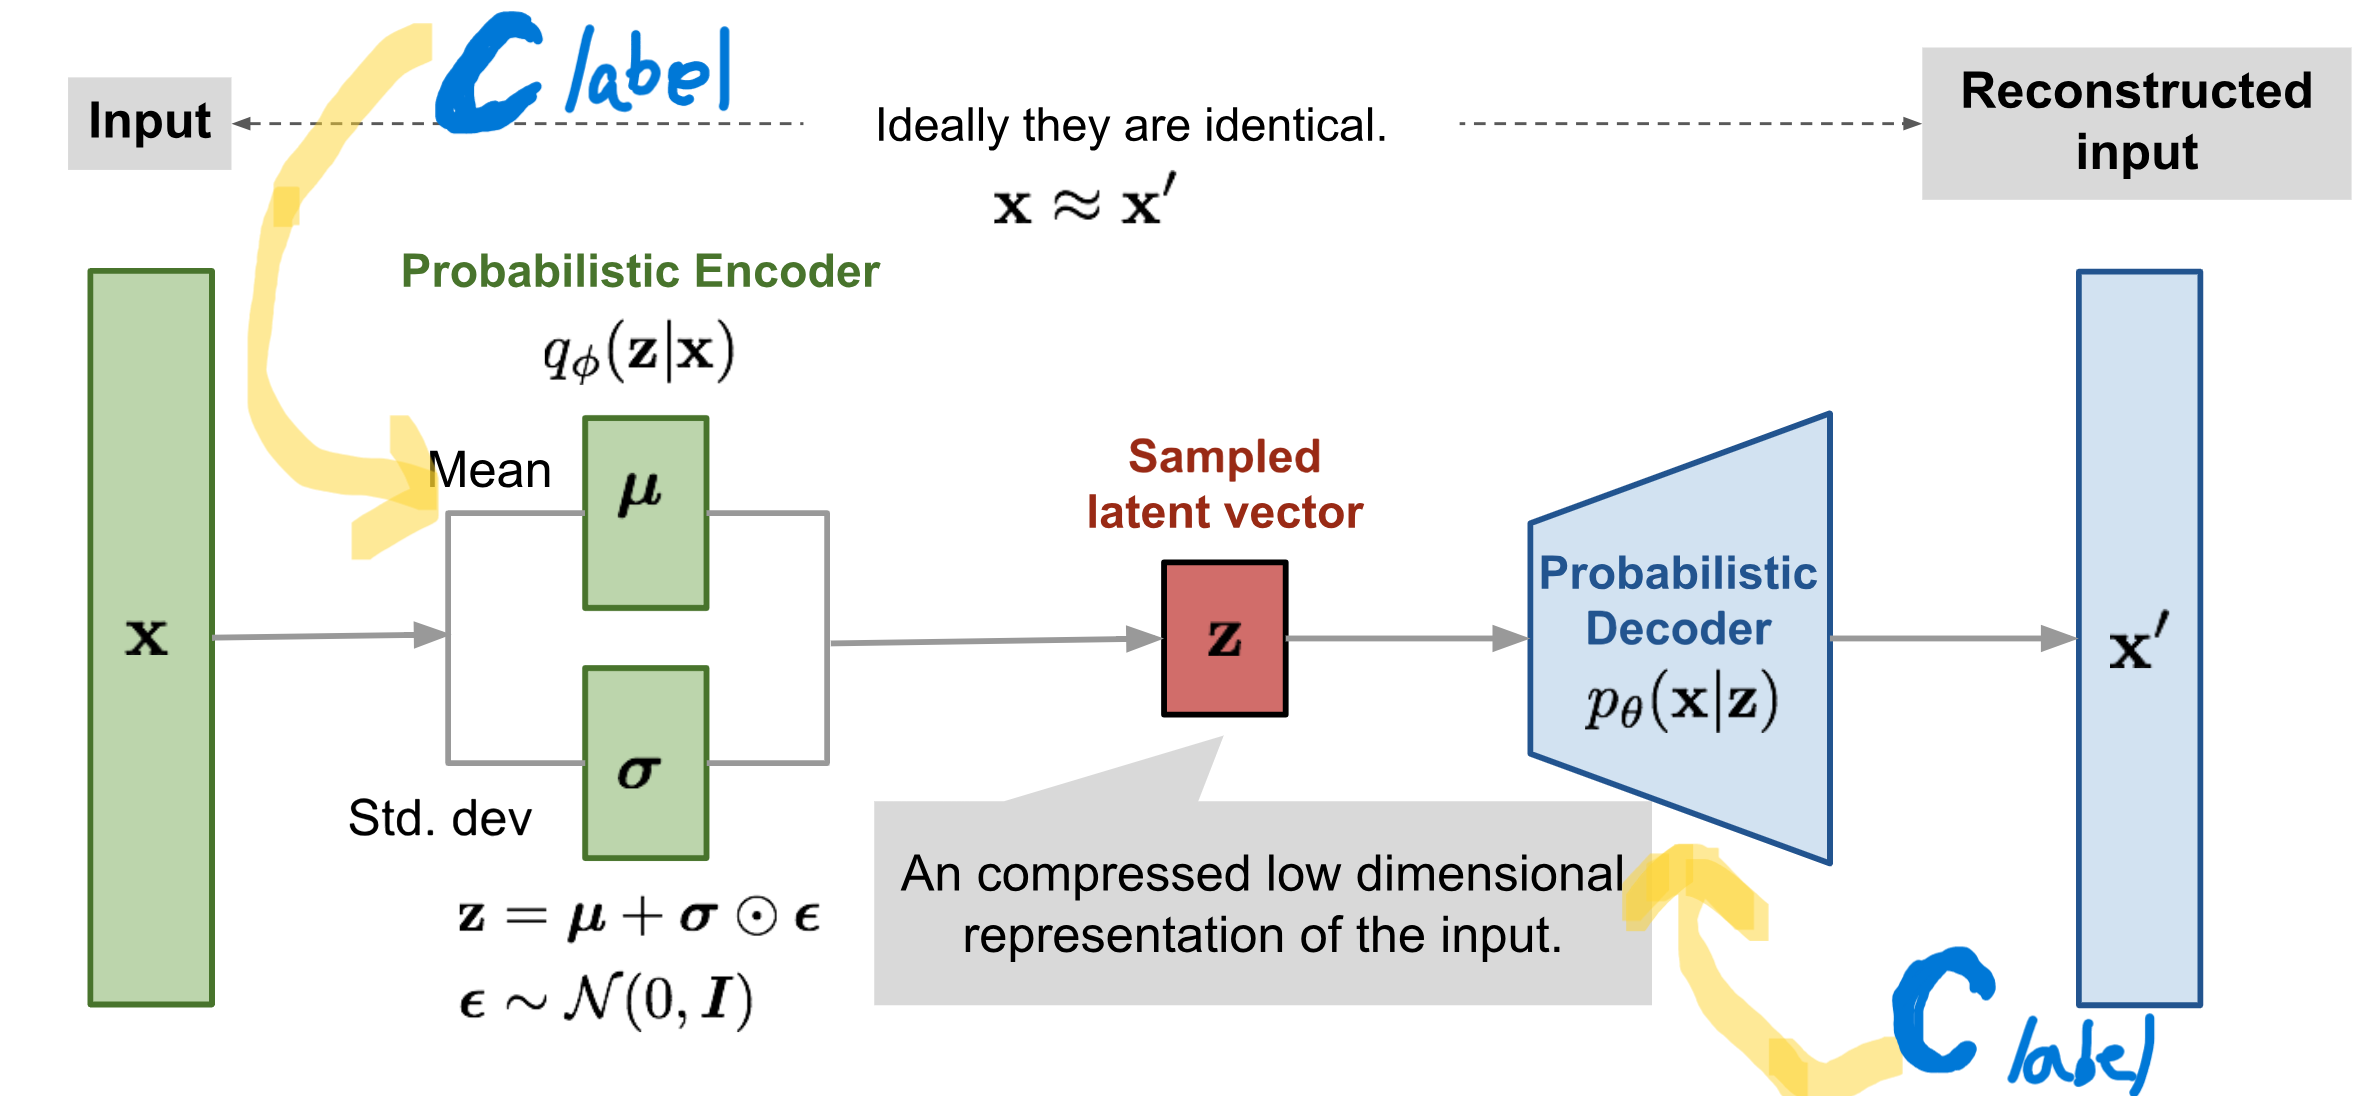

1.  The Input space along with the conditional data has dim ( 1, 50 ,2 )
2.  Which Convolves into encoder network to ( 32,34,1 ) , kernal=16,2 , no. of params= ( 16 * 2 * 1+1)*32
3.  Which again goes through the 2nd layer of convolution to ( 64, 26 ,1 ) , kernal=8,1 , params = (8* 1 * 32+1)*64
4.  This Flattens to latent Space dimensions for getting mean and variance of distributions , params = ((1664* 2)+2)*2
5.  Furthur sampling from this distribution gives us z in our latent space
6.  After performing the reparameterization trick ( sampling epsilon from Gaussian and using linear transformation) and training z_hat
7. We move to the decoder part where the Neural Network remains the same but the the generation is based off the labels or conditions to known data.






Now as we discussed the CVAE Algorithm , we can clearly see that the following Hyperparameters and Changes can play a big role of the model's outcomes.

The Hyperparameters that affect the model are :

1.   Loss Function: There are various loss functions we can apply for reconstrcution of the inout vector , for classification problems we mostly come across using Cross Entropy loss function , but since out data is generative problem , we will use MSE or L2 , L1-Mean ( MAE ), L1-Sum as out choices for loss function.

    *   MSE ( Mean Squared Error ) -

          *   It is sensitive to outliers , hence less robust and assigns larger penalties to large deviations from the target value.
          *   Useful in regression problems and is suitable for continuous data where the exact match between the predicted and actual values is important.
          *   Does not perform well under large scale of input data

    *   L1-Mean ( Mean Absolute Error ) -

          *   Less sensitive , hence more robust to outliers
          *   Often used in situations where large errors are undesirable but occasional large errors are tolerable , as it tends to push some of the weights to zero, which can be beneficial in feature selection.

    *   L1-Sum -
    
          *   Functions as L1-Mean but doesnt take average of the losses
          *   Used  for comparison purposes

2.   Initialisation of Weights:
    *   Apart from using Zero Initalisation , we can use Methods like:

      * Xavier/Glorot Initialization: Also known as variance scaling initialization, this method scales the weights based on the number of input and output units, making it suitable for layers with **sigmoid and tanh** activation functions.
      * He Initialization: Similar to Xavier, but scales the weights based on the number of input units, making it suitable for layers with **ReLU activation functions.**
      * Orthogonal Initialization: Generates weights orthogonal to the preceeding layer's weights, which can help preserve the scale of activations and reduce the chance of vanishing or exploding gradients.
      * Random Initialization: Assigns small random numbers to weights. This is a simple method that doesn't rely on any assumptions about the activation function or the scale of activations

      The only right choice of initialization is He or Random Initialisation as our problem is less categorical and more regression based , therefore we will be using ReLu and He Initialisation in our model.

3.  Latent Dimensions:

      *   Generalization: If the latent dimensions are too high , there is a possibility of acquiring even complex patterns in the datasets , this can be beneficial for a bigger dataset , however it comes with cost of overfitting .

      A smaller Latent space has an opposite affect and thus underfitting
      *   Sampling: While sampling from a large latent space ( with respect to dataset ) , the sampled z_hat can be distorted as it takes into account a large variety of features , hence can give deviating results.

      While, on the other hand, if the latent space is small, the model has limited variability to sample from, which can make it challenging to generate diverse and distinguishing results.

      Therefore selecting the right latent space can be very important.
      In our case 10 is very low , 65-120 can be optimum latent space


4.  Beta ( Intensity of ( regularization) Minimisation Dkl loss ):

      *   Reconstruction Accuracy: A lower beta value increases the importance of the reconstruction loss relative to the KL divergence loss. This encourages the model to focus more on accurately reconstructing the input data, which is crucial for tasks where fidelity to the original data is essential.  But the model Penalises the distributions ( decoder Distribution) Q(Z/X) with Z~N(0,1)( coming from ( encoder distribution) after reparameterization technique) P(z) much less , therfore increasing the risk of creating transition data points ( the data points where the sampling is unknown or obscure)

      * Latent Space Regularization: A higher beta value places more emphasis on the KL divergence term, leading to a more regularized latent space. This regularization helps prevent overfitting and encourages the model to learn a more structured and meaningful representation of the data in the latent space
      * If Beta =0 , Penalises reconstruction loss heavily , therfore it has less correlation with prior disrtribution to describe data


5.  Wx and Wy ( intensity of Minimisation of reconstruction Loss ):

      *   To minimise the Losses and bring the results closer to actual x/y , we can increase the dependency of wx and wy on average loss
      *   wx: This Hyperparamter is for the reconstruction loss of the input data (x_loss).A higher value of wx increases the emphasis on accurately reconstructing the input data.

      * wy: This Hyperparameter is for the reconstruction loss of the conditional data (y_loss).A higher value of wy places more emphasis on accurately reconstructing the conditional data, while a lower value reduces its importance.
      * If Wx or Wy= 0 , it acts as an Variational AutoEncoder as one of the distribution is effectively representing a singular value because of small variance.



In [ ]:
number_of_functions = len(functions)

# Customize your Model’s Architecture Based on next dictionary
model_parameters = {
    "number_of_points": 50,
    "number_of_inputs": 2,
    "number_of_functions": number_of_functions,
    "bias": True,
    "in_channels1": 1,
    "out_channels1": 32,
    "kernel_size1": [16, 2],
    "out_channels2": 64,
    "kernel_size2": [8, 1]
}
LossFunctions = {
    "l1": nn.L1Loss(reduction='mean'),
    "l1_sum": nn.L1Loss(reduction='sum'),
    "mse": nn.MSELoss(),
    # Add other loss functions as needed
}

selected_loss_key = "l1"  # Change this to the key of the desired loss function
loss_fn = LossFunctions[selected_loss_key]


with open('config_model.yaml', 'w') as f:
    yaml.dump(model_parameters, f)


# Define the input dimensions
number_of_points = 50
number_of_inputs = model_parameters['number_of_inputs']
number_of_functions = model_parameters['number_of_functions']
input_shape = (1, number_of_points, number_of_inputs)
cond_shape = (number_of_points, number_of_functions)


# Define initial state of hyperparameters
hyperparameters = {
    "latent_dim": 100,
    "lr" : 0.0001,
    "batch_size" : 500,
    "beta" : 1,
    "wx": 0,
    "wy": 0,
    "num_epochs":30
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=100, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=100, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

### 2.2. Generate samples from the untrained model

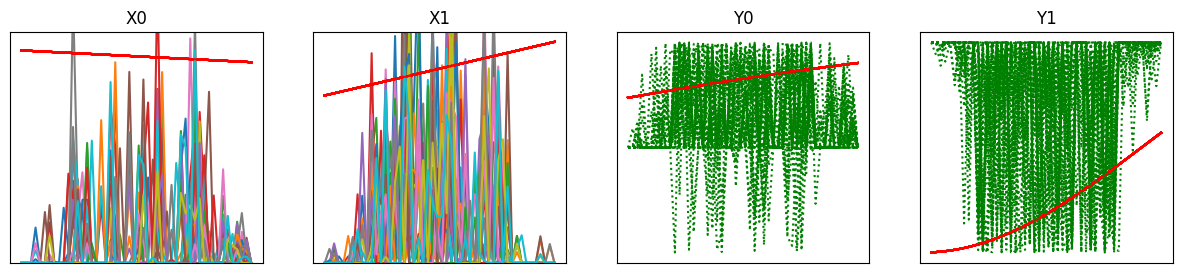

In [ ]:
# update PyTorch DataLoader with current value of batch_size
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
num_samples = 30

x_batch, y_batch = next(iter(dataloader))
y_idx = np.random.randint(batch_size)
given_x = x_batch[y_idx].unsqueeze(0).to(device)
given_y = y_batch[y_idx].unsqueeze(0).to(device)

given_y = torch.reshape(given_y, (len(given_y), number_of_points* number_of_functions))

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)


### 2.3. Train & validate model

In [ ]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)


Train Epoch 1: Average Loss: 3.061366, KDL: 3.061366, x_loss: 0.542873, y_loss: 0.883561
{'epoch': 1, 'average_loss': 3.061365595757961, 'KLD_loss': 3.061365595757961, 'x_loss': 0.5428729075193405, 'y_loss': 0.883561089336872}
Train Epoch 2: Average Loss: 0.013594, KDL: 0.013594, x_loss: 0.542863, y_loss: 0.883967
{'epoch': 2, 'average_loss': 0.013593533039093018, 'KLD_loss': 0.013593533039093018, 'x_loss': 0.5428630664944649, 'y_loss': 0.8839674347639084}
Train Epoch 3: Average Loss: 0.005936, KDL: 0.005936, x_loss: 0.542936, y_loss: 0.883445
{'epoch': 3, 'average_loss': 0.0059361918270587925, 'KLD_loss': 0.0059361918270587925, 'x_loss': 0.5429356092214584, 'y_loss': 0.8834446275234222}
Train Epoch 4: Average Loss: 0.003994, KDL: 0.003994, x_loss: 0.542999, y_loss: 0.883591
{'epoch': 4, 'average_loss': 0.003994126617908478, 'KLD_loss': 0.003994126617908478, 'x_loss': 0.5429989326000214, 'y_loss': 0.8835906204581261}
Train Epoch 5: Average Loss: 0.002780, KDL: 0.002780, x_loss: 0.54294

0.00011026263236999512

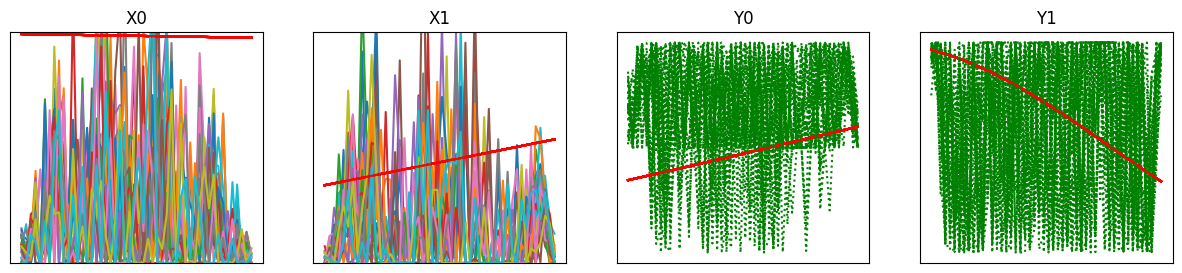

In [ ]:
x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

As , we can see that due to no reconstruction error , there is random increase and decrease in reconstructed data ,since KL divergence is only applied here , effectively each spike is representing a discrete data point due to low variance .

### 2.4. Hyperparameter's tuning process


#### 2.4.1 Test Cases: Loss function = L1_mean

1.   $\beta$ = 1 , W1=0 , W2=0 ( above test case )
2.   $\beta$ = 0 , W1=1 , W2=0, latent_dim=100
3.  $\beta$ = 0 , W1=1 , W2=1, latent_dim=100
4.  $\beta$ = 1 , W1=0.5 , W2=0.5, latent_dim=100
5.  $\beta$ = 0.8 , W1=0.6 , W2=0.6, latent_dim=60
6.  $\beta$ = 0.8 , W1=0.65 , W2=0.72 , latent_dim=85


In [ ]:
selected_loss_key = "l1"  # Change this to the key of the desired loss function
loss_fn = LossFunctions[selected_loss_key]

##### 2. $\beta$ = 0 , W1=1 , W2=0

In [ ]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 100,
    "lr" : 0.0001,
    "batch_size" : 500,
    "beta" : 0,
    "wx": 1,
    "wy": 0,
    "num_epochs":30
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=100, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=100, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 0.128761, KDL: 156848.583680, x_loss: 0.128761, y_loss: 0.367226
{'epoch': 1, 'average_loss': 0.12876090517267585, 'KLD_loss': 156848.58368019105, 'x_loss': 0.12876090517267585, 'y_loss': 0.36722595021128657}
Train Epoch 2: Average Loss: 0.033118, KDL: 288479.651250, x_loss: 0.033118, y_loss: 0.132856
{'epoch': 2, 'average_loss': 0.033117730477824806, 'KLD_loss': 288479.65125, 'x_loss': 0.033117730477824806, 'y_loss': 0.13285556569695472}
Train Epoch 3: Average Loss: 0.026080, KDL: 322716.792969, x_loss: 0.026080, y_loss: 0.108453
{'epoch': 3, 'average_loss': 0.026080355020239948, 'KLD_loss': 322716.79296875, 'x_loss': 0.026080355020239948, 'y_loss': 0.10845332629978657}
Train Epoch 4: Average Loss: 0.021660, KDL: 344376.832500, x_loss: 0.021660, y_loss: 0.094935
{'epoch': 4, 'average_loss': 0.02165967387147248, 'KLD_loss': 344376.8325, 'x_loss': 0.02165967387147248, 'y_loss': 0.09493535079061985}
Train Epoch 5: Average Loss: 0.020048, KDL: 357859.872500, x

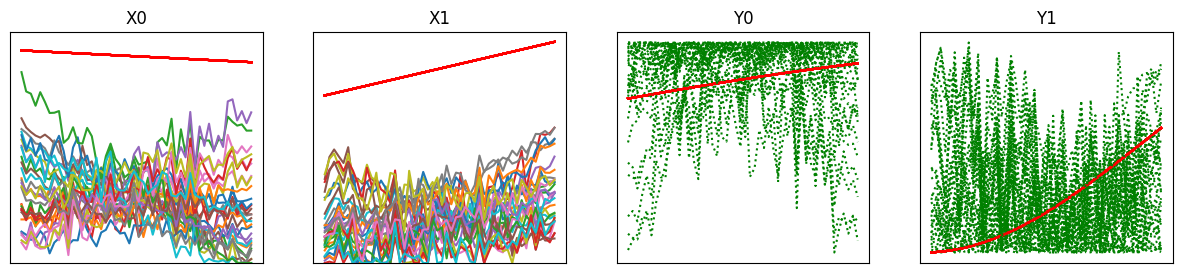

In [ ]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

As we can see Wx=1 and rest factors are zero , there is reconstruction ( which means , now the lines try to make sense of increasing or decreasing pattern ) , this creates a more systematic data trend but due to lack of KL divergence , there is no correlation with actual data , similarly y also shows a spiky data due to Wy=0

##### 3. $\beta$ = 0 , W1=1 , W2=1

In [ ]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 100,
    "lr" : 0.0001,
    "batch_size" : 500,
    "beta" : 0,
    "wx": 1,
    "wy": 1,
    "num_epochs":30
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=100, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=100, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 0.513259, KDL: 163789.441204, x_loss: 0.140999, y_loss: 0.372259
{'epoch': 1, 'average_loss': 0.5132586099207401, 'KLD_loss': 163789.44120376586, 'x_loss': 0.14099925145506859, 'y_loss': 0.37225935779511926}
Train Epoch 2: Average Loss: 0.157958, KDL: 319052.466875, x_loss: 0.031705, y_loss: 0.126254
{'epoch': 2, 'average_loss': 0.15795827016234398, 'KLD_loss': 319052.466875, 'x_loss': 0.03170452609658241, 'y_loss': 0.12625374432653189}
Train Epoch 3: Average Loss: 0.131088, KDL: 356442.337500, x_loss: 0.025124, y_loss: 0.105964
{'epoch': 3, 'average_loss': 0.13108775310218335, 'KLD_loss': 356442.3375, 'x_loss': 0.025123637495562436, 'y_loss': 0.10596411567181349}
Train Epoch 4: Average Loss: 0.122469, KDL: 377262.618125, x_loss: 0.022475, y_loss: 0.099994
{'epoch': 4, 'average_loss': 0.12246939595788717, 'KLD_loss': 377262.618125, 'x_loss': 0.022475381847471, 'y_loss': 0.09999401435256004}
Train Epoch 5: Average Loss: 0.115193, KDL: 381712.688906, x_loss: 

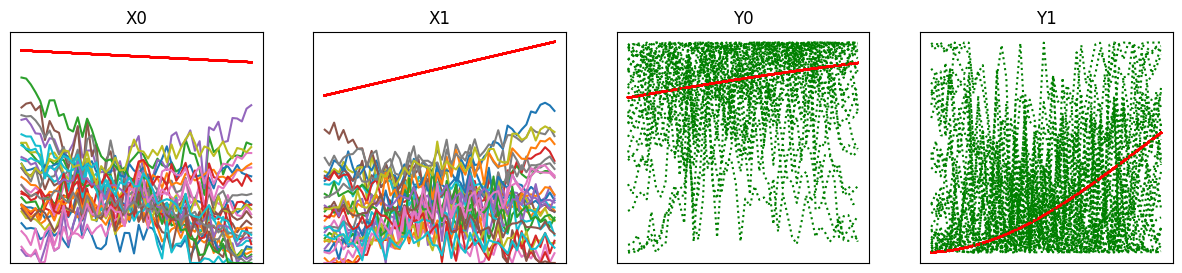

In [ ]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

Here Wy=0 shows nothing different as KL Divergenceis not applied and hence is not correlating with actual trend

##### 4. $\beta$ = 1 , W1=0.5 , W2=0.5

In [ ]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 100,
    "lr" : 0.001,
    "batch_size" : 250,
    "beta" : 1,
    "wx": 0.5,
    "wy": 0.5,
    "num_epochs":30
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=100, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=100, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 0.681414, KDL: 0.440042, x_loss: 0.127833, y_loss: 0.354910
{'epoch': 1, 'average_loss': 0.6814136243611574, 'KLD_loss': 0.44004206903278825, 'x_loss': 0.12783310210332274, 'y_loss': 0.3549100409448147}
Train Epoch 2: Average Loss: 0.172117, KDL: 0.000356, x_loss: 0.093663, y_loss: 0.249859
{'epoch': 2, 'average_loss': 0.17211678925901652, 'KLD_loss': 0.00035569384694099425, 'x_loss': 0.09366316402330994, 'y_loss': 0.2498590263724327}
Train Epoch 3: Average Loss: 0.154901, KDL: 0.000266, x_loss: 0.086129, y_loss: 0.223140
{'epoch': 3, 'average_loss': 0.154900545142591, 'KLD_loss': 0.00026617832481861113, 'x_loss': 0.08612865153700114, 'y_loss': 0.22314008217304945}
Train Epoch 4: Average Loss: 0.144068, KDL: 0.000231, x_loss: 0.081057, y_loss: 0.206615
{'epoch': 4, 'average_loss': 0.14406771091744303, 'KLD_loss': 0.00023133568465709685, 'x_loss': 0.08105735093355179, 'y_loss': 0.2066153996437788}
Train Epoch 5: Average Loss: 0.138383, KDL: 0.000333, x_loss:

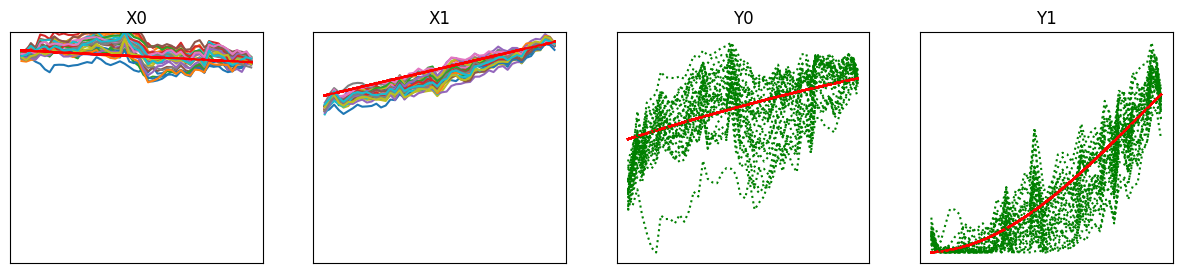

In [21]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

Here , Both are applied and hence Data points make more sense and start to show a linear trend and path of y as well , our total loss is very less as well ,
this could be near something we are looking for our latent space may be a bit higher , we can try adjusting it

##### 5. $\beta$ = 0.8 , W1=0.6 , W2=0.6

In [23]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 60,
    "lr" : 0.001,
    "batch_size" : 250,
    "beta" : 0.8,
    "wx":0.6,
    "wy": 0.6,
    "num_epochs":25
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=60, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=60, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 0.489361, KDL: 0.216950, x_loss: 0.135090, y_loss: 0.391245
{'epoch': 1, 'average_loss': 0.4893612782657146, 'KLD_loss': 0.21695040263235568, 'x_loss': 0.1350895287655294, 'y_loss': 0.39124537624418737}
Train Epoch 2: Average Loss: 0.215437, KDL: 0.000281, x_loss: 0.093538, y_loss: 0.265149
{'epoch': 2, 'average_loss': 0.21543661274015904, 'KLD_loss': 0.0002807906270027161, 'x_loss': 0.09353807037696242, 'y_loss': 0.26514854982495306}
Train Epoch 3: Average Loss: 0.186313, KDL: 0.000110, x_loss: 0.084034, y_loss: 0.226342
{'epoch': 3, 'average_loss': 0.18631321605294943, 'KLD_loss': 0.00010970816016197205, 'x_loss': 0.08403404131531715, 'y_loss': 0.22634169459342957}
Train Epoch 4: Average Loss: 0.174514, KDL: 0.000125, x_loss: 0.079171, y_loss: 0.211519
{'epoch': 4, 'average_loss': 0.17451373439282178, 'KLD_loss': 0.0001245829463005066, 'x_loss': 0.07917067792266608, 'y_loss': 0.21151942387223244}
Train Epoch 5: Average Loss: 0.166406, KDL: 0.000090, x_los

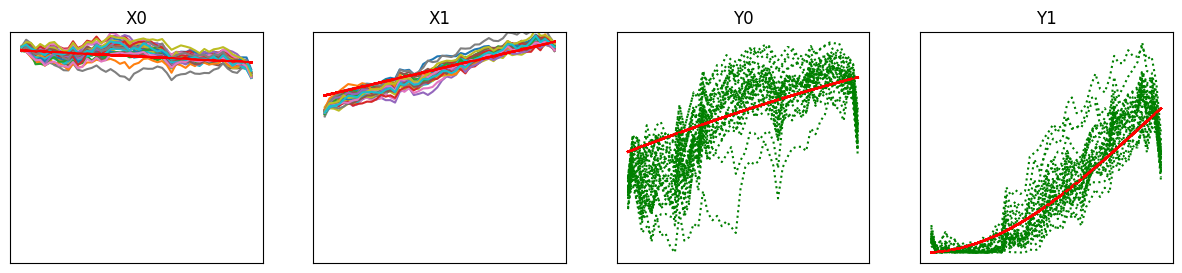

In [24]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

Decreasing latent space creates more deviation from actual y , maybe increasing it can help

##### 6. $\beta$ = 0.8 , W1=0.65 , W2=0.72 , latent_dim=85

In [39]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 85,
    "lr" : 0.001,
    "batch_size" : 250,
    "beta" : 0.8,
    "wx":0.65,
    "wy": 0.72,
    "num_epochs":25
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=85, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=85, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 0.786616, KDL: 0.509422, x_loss: 0.139113, y_loss: 0.400909
{'epoch': 1, 'average_loss': 0.7866155190020799, 'KLD_loss': 0.5094221541285515, 'x_loss': 0.13911289416253567, 'y_loss': 0.4009088715910912}
Train Epoch 2: Average Loss: 0.260836, KDL: 0.000433, x_loss: 0.096090, y_loss: 0.275043
{'epoch': 2, 'average_loss': 0.26083601973950865, 'KLD_loss': 0.0004334045946598053, 'x_loss': 0.09608956711366773, 'y_loss': 0.2750431539863348}
Train Epoch 3: Average Loss: 0.230387, KDL: 0.000295, x_loss: 0.087465, y_loss: 0.240693
{'epoch': 3, 'average_loss': 0.23038664098829031, 'KLD_loss': 0.0002946709096431732, 'x_loss': 0.0874646838195622, 'y_loss': 0.24069285336881877}
Train Epoch 4: Average Loss: 0.210802, KDL: 0.000202, x_loss: 0.081899, y_loss: 0.218619
{'epoch': 4, 'average_loss': 0.21080194119364024, 'KLD_loss': 0.00020246550440788268, 'x_loss': 0.08189944088459016, 'y_loss': 0.2186185112595558}
Train Epoch 5: Average Loss: 0.203157, KDL: 0.000182, x_loss: 0

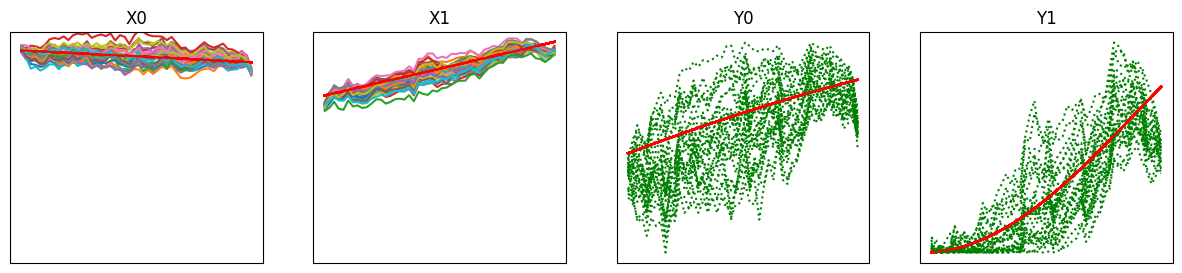

In [40]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

We can Clearly see that xloss and yloss comes to a saturation way before KL_loss this means we need to increase beta and to avoid noise we need to increase latent space furthur

#### 2.4.2 Test Cases: Loss function = MSE

1.  $\beta$ = 1 , W1=0.5 , W2=0.5
2.  $\beta$ = 0.8 , W1=0.6 , W2=0.6

In [25]:
selected_loss_key = "mse"  # Change this to the key of the desired loss function
loss_fn = LossFunctions[selected_loss_key]

##### 1. $\beta$ = 1 , W1=0.5 , W2=0.5

In [26]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 65,
    "lr" : 0.001,
    "batch_size" : 250,
    "beta" : 1,
    "wx": 0.5,
    "wy": 0.5,
    "num_epochs":25
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=65, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=65, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 0.433409, KDL: 0.252356, x_loss: 0.034097, y_loss: 0.328009
{'epoch': 1, 'average_loss': 0.4334087802097201, 'KLD_loss': 0.25235553592443466, 'x_loss': 0.03409723779652268, 'y_loss': 0.32800923448055985}
Train Epoch 2: Average Loss: 0.117280, KDL: 0.000150, x_loss: 0.020592, y_loss: 0.213669
{'epoch': 2, 'average_loss': 0.1172798883356154, 'KLD_loss': 0.00014950096607208252, 'x_loss': 0.020592271687928588, 'y_loss': 0.2136685025319457}
Train Epoch 3: Average Loss: 0.100412, KDL: 0.000322, x_loss: 0.017654, y_loss: 0.182526
{'epoch': 3, 'average_loss': 0.10041242418810725, 'KLD_loss': 0.0003224211186170578, 'x_loss': 0.017654474107548595, 'y_loss': 0.1825255320034921}
Train Epoch 4: Average Loss: 0.093106, KDL: 0.000163, x_loss: 0.016085, y_loss: 0.169801
{'epoch': 4, 'average_loss': 0.09310618606396019, 'KLD_loss': 0.0001632080227136612, 'x_loss': 0.016085074550937863, 'y_loss': 0.1698008816316724}
Train Epoch 5: Average Loss: 0.086758, KDL: 0.000221, x_los

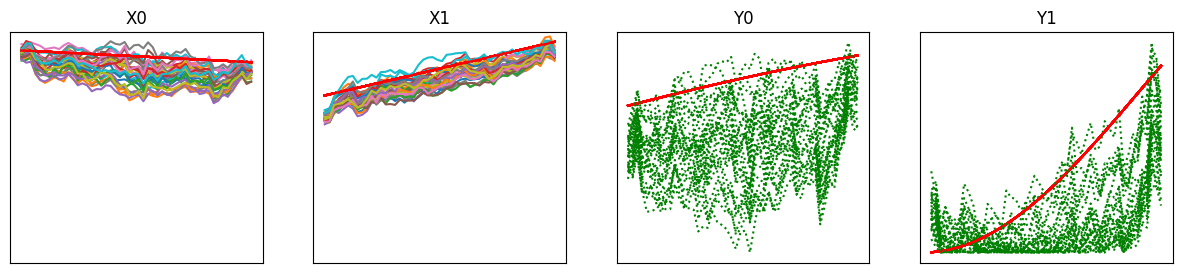

In [27]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

##### 2. $\beta$ = 0.9 , W1=0.6 , W2=0.8

In [28]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 120,
    "lr" : 0.001,
    "batch_size" : 250,
    "beta" : 0.9,
    "wx": 0.6,
    "wy": 0.8,
    "num_epochs":25
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=120, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=120, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 0.693747, KDL: 0.409224, x_loss: 0.040265, y_loss: 0.376608
{'epoch': 1, 'average_loss': 0.693747006803751, 'KLD_loss': 0.4092242802679539, 'x_loss': 0.04026462866459042, 'y_loss': 0.3766079657524824}
Train Epoch 2: Average Loss: 0.206596, KDL: 0.000141, x_loss: 0.022298, y_loss: 0.241363
{'epoch': 2, 'average_loss': 0.206596008092165, 'KLD_loss': 0.00014079898595809937, 'x_loss': 0.022297509969212113, 'y_loss': 0.24136347457766533}
Train Epoch 3: Average Loss: 0.179907, KDL: 0.000070, x_loss: 0.019761, y_loss: 0.209985
{'epoch': 3, 'average_loss': 0.17990728426724673, 'KLD_loss': 6.956785917282104e-05, 'x_loss': 0.019760899238754064, 'y_loss': 0.20998516235500575}
Train Epoch 4: Average Loss: 0.162508, KDL: 0.000039, x_loss: 0.017839, y_loss: 0.189711
{'epoch': 4, 'average_loss': 0.16250789720565081, 'KLD_loss': 3.942050039768219e-05, 'x_loss': 0.01783869745908305, 'y_loss': 0.18971149602904916}
Train Epoch 5: Average Loss: 0.153894, KDL: 0.000020, x_loss:

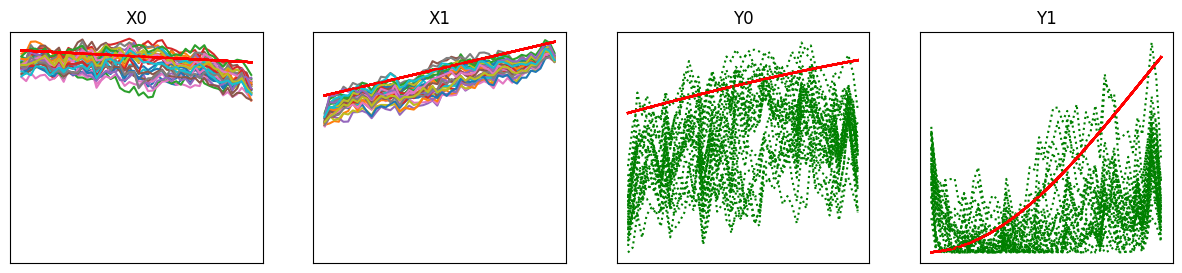

In [29]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

Clearly MSE Produces much more punishment to the outliers causing a much more distorted data.

#### 2.4.3 Test Cases: Loss function = L1_sum

1.  $\beta$ = 1 , W1=0.5 , W2=0.5

In [30]:
selected_loss_key = "l1_sum"  # Change this to the key of the desired loss function
loss_fn = LossFunctions[selected_loss_key]

##### 1. $\beta$ = 0.4 , W1=0.6 , W2=0.7

In [32]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 80,
    "lr" : 0.001,
    "batch_size" : 250,
    "beta" : 0.4,
    "wx": 0.6,
    "wy": 0.7,
    "num_epochs":25
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=80, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=80, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 8293.466884, KDL: 453.883388, x_loss: 2573.425285, y_loss: 9382.654850
{'epoch': 1, 'average_loss': 8293.466883544921, 'KLD_loss': 453.8833876037598, 'x_loss': 2573.4252850341795, 'y_loss': 9382.654849853516}
Train Epoch 2: Average Loss: 5072.961430, KDL: 562.874778, x_loss: 1286.182608, y_loss: 5823.002816
{'epoch': 2, 'average_loss': 5072.9614300537105, 'KLD_loss': 562.8747776794434, 'x_loss': 1286.1826077270507, 'y_loss': 5823.002816162109}
Train Epoch 3: Average Loss: 4096.521879, KDL: 577.084205, x_loss: 1028.207371, y_loss: 4641.091149
{'epoch': 3, 'average_loss': 4096.521879272461, 'KLD_loss': 577.0842050170899, 'x_loss': 1028.2073713684083, 'y_loss': 4641.091149291992}
Train Epoch 4: Average Loss: 3507.553932, KDL: 581.481299, x_loss: 885.944274, y_loss: 3919.135524
{'epoch': 4, 'average_loss': 3507.5539318847655, 'KLD_loss': 581.4812992858887, 'x_loss': 885.9442735290527, 'y_loss': 3919.135524291992}
Train Epoch 5: Average Loss: 3142.463117, KDL: 5

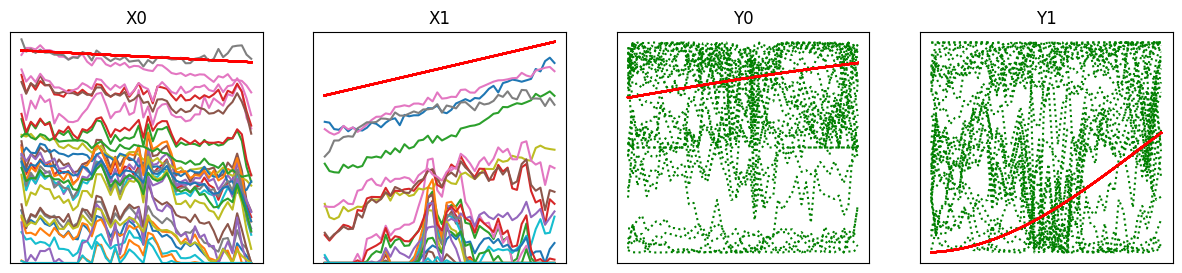

In [33]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

Clearly Only Sum loss function produces a random result as our loss is very random and starts off with a very high loss , this indicates a bad loss function

## 2.5 Optimised Model and Appropriate Hyperparameters

From Above test cases we can derive :

1. Latent space> 100
2. beta>1
3. 0.7 >wx > 0.5
4. 0.65>wy>0.5
5. Min epochs = 25

In [38]:
selected_loss_key = "l1"  # Change this to the key of the desired loss function
loss_fn = LossFunctions[selected_loss_key]

In [45]:
# Define state of hyperparameters
hyperparameters = {
    "latent_dim": 110,
    "lr" : 0.001,
    "batch_size" : 500,
    "beta" : 1.1,
    "wx": 0.6,
    "wy": 0.6,
    "num_epochs":25
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()

cvae = CVAE.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

print("Current CVAE configuration: ")
model

Current CVAE configuration: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=110, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=110, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): LazyLinear(in_features=0, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

Train Epoch 1: Average Loss: 3.636842, KDL: 3.001531, x_loss: 0.146920, y_loss: 0.411677
{'epoch': 1, 'average_loss': 3.63684196151793, 'KLD_loss': 3.0015306079387667, 'x_loss': 0.14691958542913197, 'y_loss': 0.41167747125029563}
Train Epoch 2: Average Loss: 0.225155, KDL: 0.002623, x_loss: 0.099149, y_loss: 0.271300
{'epoch': 2, 'average_loss': 0.22515483789145946, 'KLD_loss': 0.002623035907745361, 'x_loss': 0.09914879668504, 'y_loss': 0.27130035430192945}
Train Epoch 3: Average Loss: 0.201047, KDL: 0.001054, x_loss: 0.091233, y_loss: 0.241912
{'epoch': 3, 'average_loss': 0.2010465381294489, 'KLD_loss': 0.001053714007139206, 'x_loss': 0.09123326163738966, 'y_loss': 0.24191248014569283}
Train Epoch 4: Average Loss: 0.188859, KDL: 0.001261, x_loss: 0.086557, y_loss: 0.225896
{'epoch': 4, 'average_loss': 0.18885889306664466, 'KLD_loss': 0.0012614057958126067, 'x_loss': 0.08655654188245535, 'y_loss': 0.2258956888318062}
Train Epoch 5: Average Loss: 0.181251, KDL: 0.000533, x_loss: 0.08335

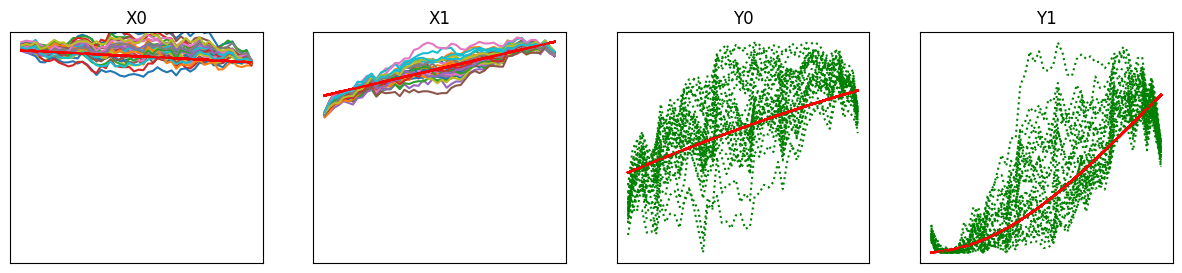

In [46]:
# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
random_seed = 0 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

for epoch in range(1, num_epochs + 1):
    epoch_result = CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, functions,loss_fn)
    print(epoch_result)

CVAE_fn.test_cvae(model, validation_loader,beta, wx, wy, functions,loss_fn)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))

CVAE_fn.plot_samples_stacked(given_x, x_output.cpu(), y_output.cpu(),fun_list = functions)

## 3. Generation of reconstructed X0/X1 pairs and saving results

In [47]:
filename_scoring_dataset = f'{data_root}scoring{filename}.pt'
scoring_dataset = CVAE_fn.SignalDataset(torch.load(filename_scoring_dataset))

print(f"Scoring dataset is loaded successfully and has length: {len(scoring_dataset)}")

# create a PyTorch DataLoader from the scoring_dataset
scoring_loader = DataLoader(scoring_dataset, batch_size=len(scoring_dataset), shuffle=True)

num_samples = 30
x_batch, y_batch = next(iter(scoring_loader))
x_out= []
y_out = []
for idx in range(len(y_batch)):
    given_y = y_batch[idx].unsqueeze(0).to(device)
    given_y = torch.reshape(given_y, (len(given_y), number_of_points * number_of_functions))
    x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape)
    # y_output = torch.reshape(y_output, (len(y_output), 1, number_of_points, number_of_functions))
    x_out.append(x_output)
    y_out.append(y_output)
    '''
    Combine all generated samples together.
    Be carefull -  y_output here are GIVEN Y1/Y1. y_hat (aka reconstructed Y1/Y2) always could  be calculated
    by x_output, so it should not be stored in result file.
    '''

x_outputs = torch.cat(x_out, dim=0)
y_outputs = torch.cat(y_out, dim=0)
x_outputs = x_outputs.cpu()
y_outputs = y_outputs.cpu()


# Save result as TensorDataset before submitting, for example like next:
# Pay attention the code below doesn't work unless you have comleted generation x_ouputs/y_outputs above.

ds = data_utils.TensorDataset(x_outputs,y_outputs)
torch.save(ds, 'result/result_dataset.pt')



Scoring dataset is loaded successfully and has length: 50


In [ ]:
x_out

In [49]:
x_new=x_outputs.squeeze(1)

In [50]:
x_new.size()

torch.Size([1500, 50, 2])

In [51]:
x_new[1499].size()

torch.Size([50, 2])

In [52]:
tensor_matrix = x_new[1].numpy()  # Convert tensor to NumPy array
matrix = np.matrix(tensor_matrix)

In [ ]:
matrix

In [53]:
x_new[:30].size()

torch.Size([30, 50, 2])

In [ ]:
x_new[29]

## Submission

### Pearson Coeffient Analysis

In [ ]:
import torch
from scipy.stats import pearsonr

# Assuming x_outputs is your tensor of size [1500, 1, 50, 2]

# Reshape the tensor to have shape [1500, 50, 2]
x_reshaped = x_outputs.squeeze(1)

# Initialize a list to store Pearson correlation coefficients
pearson_coeffs = []

# Iterate through the first dimension (1500)
for i in range(x_reshaped.size(0)):
    # Get the data for the current test case
    data = x_reshaped[i]

    # Calculate Pearson correlation coefficient for each pair of slices
    for j in range(30):
        # Calculate the index range for the first 50 elements and the next 50 elements
        start_index = (j) * 50
        end_index = (j + 1) * 50

        # Extract the slices of data
        slice1 = data[start_index:end_index]
        slice2 = data[x_given_start :x_given_end]  # Adjust the start index for the second slice
        print(slice2[:,0])
        # Calculate Pearson correlation coefficient
        coeff, _ = pearsonr(slice1[:, 0], slice2[:, 0])

        # Append the coefficient to the list
        pearson_coeffs.append(coeff)

# Convert the list to a tensor
pearson_coeffs_tensor = torch.tensor(pearson_coeffs)

# Reshape the tensor to match the original test case structure
pearson_coeffs_tensor = pearson_coeffs_tensor.view(1500, 30)

# pearson_coeffs_tensor now contains the Pearson correlation coefficients for each test case and each pair of slices


### Reconstruction Error Analysis ( RMSE )

### Variance calculation

In [55]:
import torch

x_new = torch.randn(1500, 50, 2)

variance = torch.var(x_new, dim=1)
print("Variance for each test case and each feature:")
print(variance)
total_variance = torch.var(x_new, dim=(0, 1))
print("\nTotal variance for each feature across all test cases:")
print(total_variance)


Variance for each test case and each feature:
tensor([[0.9466, 0.5702],
        [0.8692, 1.0580],
        [0.7196, 0.7629],
        ...,
        [0.9115, 0.9205],
        [1.0212, 0.8789],
        [0.8953, 1.3756]])

Total variance for each feature across all test cases:
tensor([1.0091, 1.0028])


In [ ]:
variance.size()

torch.Size([1500, 2])